# Finding pumps that give locally optimal spectral purity

This notebook showcases a local optimization scheme applied on mode purity for SPDC phenomenon in waveguides. The optimization will use penalty method with the average number of photon pairs generated per pulse as a constraint and the spectral purity of generated pair and the variance of the pump as the objective function. 2 seeds are used; one that is a Hermite polynomial multiplied by a Gaussian and a random vector.

## Theory

The dynamics describing SPDC can be seen as 

$
\frac{\partial }{\partial z}a_S(z, \omega) = \text{i}\omega \Delta k_S a_S(z, \omega) + \frac{\text{i}\gamma (z)}{\sqrt{2\pi}}\int \beta (\omega + \omega ')a_I^\dagger (z, \omega ')d\omega ',\\
\frac{\partial }{\partial z}a_I^\dagger(z, \omega) = -\text{i}\omega \Delta k_I a_I ^\dagger(z, \omega) - \frac{\text{i}\gamma ^* (z)}{\sqrt{2\pi}}\int \beta ^* (\omega + \omega ')a_S(z, \omega),
$

where $\Delta k_j = \frac{1}{v_j} - \frac{1}{v_p}$, where $v_j$ is the group velocity of the mode $j$, $\omega$ the frequency, $\beta(\omega)$ the slowly varying envelope of the pump in frequency domain, $\gamma (z)$ a tophat function associated to second order nonlinearity and $a_j (z, \omega)$ the annihilation operator for the mode $j$. The equations can be described by discretization into normal modes as

$
\frac{\partial}{\partial z}\begin{bmatrix}
\bar{a}_S(z, \omega)\\
\bar{a}_I^\dagger(z, \omega)
\end{bmatrix}=
\text{i}\begin{bmatrix}
\Delta k_S \omega & \frac{\text{i}\gamma}{\sqrt{2\pi}}\beta \\
-\frac{\text{i}\gamma ^*}{\sqrt{2\pi}}\beta ^\dagger & -\Delta k_I \omega
\end{bmatrix}
\begin{bmatrix}
\bar{a}_S(z, \omega')\\
\bar{a}_I^\dagger(z, \omega')
\end{bmatrix} = \text{i}A\begin{bmatrix}
\bar{a}_S(z, \omega')\\
\bar{a}_I^\dagger(z, \omega')
\end{bmatrix} ,
$

where $\Delta k_j \omega$ is a diagonal matrix for both values of $j$ and $\beta$ a Hankel matrix representing $\beta (\omega + \omega')$. The matrix $A$ is an element of the Lie algebra and is used to generate the propagator associate to the dynamics which will be an element of the group $SU(1,1)$.

The spectral purity of SPDC dynamics in frequency and space domain for a waveguide can be represented by the Schmidt number $K$, which can be expressed by

$
\begin{align}
K = \frac{\text{Tr}\left[U_{SI}^*U_{SI}^{T}\right]^2}{\text{Tr}\left[U_{SI}^*U_{SI}^{T}U_{SI}^*U_{SI}^{T}\right]},
\end{align}
$

where $U_{SI}$ is a block of the matrix $U$, which is an element of the group $SU(1,1)$. The constraint that the average photon number pairs is equal to $n$, which in this notebook will be 3, can be written as

$\text{Tr}\left[U_{SI}^* U_{SI}^T\right] - n = 0$,

which also used the matrix $U_{SI}$. The matrix $U$ can be obtained by exponentiating $A$ such as

$
U = 
\begin{bmatrix}
U_{SS} & U_{SI}\\
U_{IS}^* & U_{II}^*
\end{bmatrix}
=
\text{exp}\left(\text{i}\begin{bmatrix}
\Delta k_S \omega & \frac{\gamma}{\sqrt{2\pi}} \beta \\
-\frac{\gamma ^*}{\sqrt{2\pi}}\beta ^\dagger & -\Delta k_I \omega
\end{bmatrix}\right).
$

Because the theoretical minimum of the Schmidt number is 1, the objective function becomes $K-1$ and the problem becomes

$
\begin{align}
\text{min} \ & \frac{\text{Tr}\left[U_{SI}^*U_{SI}^{T}\right]^2}{\text{Tr}\left[U_{SI}^*U_{SI}^{T}U_{SI}^*U_{SI}^{T}\right]} - 1\\
\text{s. c.} \ & \text{Tr}\left[U_{SI}^* U_{SI}^T\right] - n = 0,\\
& \begin{bmatrix}
U_{SS} & U_{SI}\\
U_{IS}^* & U_{II}^*
\end{bmatrix}
=
\text{exp}\left(\text{i}\begin{bmatrix}
\Delta k \omega & \frac{\gamma}{\sqrt{2\pi}} \beta \\
-\frac{\gamma ^*}{\sqrt{2\pi}}\beta ^\dagger & \Delta k \omega
\end{bmatrix}\right).
\end{align}
$

## Import the libraries 

The library used to generate initial seed, to optimize the spectral purity and to post-process the data are imported.

In [1]:
import jax.numpy as jnp
import jax
import jaxopt
import numpy as np

import matplotlib.pyplot as plt

import optimization_SPDC as opt
import get_initialization_cond as init

key = jax.random.PRNGKey(0)

# Set general hyperparameters

Hyperparameters are set to generate the propagator describing the dynamics of SPDC and to make the optimization scheme. They include the discretized frequency domain vector, the strength and parameters used to generate the initial pump seed, the group frequency of the pump mode, the length of the nonlinear material and the number of pairs generated per pulse.

In [2]:
Np = 0.01
# higher N and wf+wi makes less unstable pump... need to see if N or wf+wi influences more
N = 601
wi = -10
wf = 10
x = jnp.linspace(wi, wf, N)
alpha_phase = 0
freq_range_pump = jnp.linspace(2*wi, 2*wf, 2*N)
freq_range_pump_complex = jnp.concatenate((freq_range_pump, freq_range_pump)).reshape(4*N,)
vp = 0.1
l = 1
# Parameters to generate pump seed
hermite_order = 2
gaussian_amplitude = 0.05
gaussian_width = 0.3
phase = jnp.pi/5
hermite_init_params = [hermite_order, gaussian_amplitude, gaussian_width, phase]
cst_init_params = [0.1]
y_N = 3

Using the initialization module, the diagonal blocks $\Delta k_j \omega$ of the propagator generator are generated as well as the seeds used to effect the optimization scheme

In [4]:
alpha, G, H = init.get_constants(vp, l, wi, wf, Np, alpha_phase, N = N)
arbitrary_seed_hermite = init.get_initialization_array(hermite_init_params, wi, wf, method='hermite', N = N)
random_seed = Np*jax.random.uniform(key, shape=(4*N,))

BFGS will be used with a penalty method algorithm on random seed as well as on a Hermitian polynomial multiplied by a Gaussian. The $\sigma _k$ value will be $3^k$.

In [5]:
solver = jaxopt.ScipyMinimize(method="BFGS", fun=opt.get_penalty_loss, maxiter=1, jit = False)

In [9]:
jax.grad(opt.get_penalty_loss)(random_seed, N, alpha, G, H, l, y_N, freq_range_pump, 0)

DeviceArray([1.0070672 , 2.0819125 , 5.8973627 , ..., 0.07152966,
             1.10458   , 2.5527034 ], dtype=float32)

In [6]:
pump = random_seed.copy()
pumps_for_k = []
for i in range(20):
    pumps = []
    print("run " + str(i))
    for j in range(15):
        (pump, state) = solver.run(pump, N, alpha, G, H, l, y_N, freq_range_pump, 3**i)
        pumps.append(pump.copy())
    pumps_for_k.append(pumps)

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19


We can visualize how the BFGS algorithm optimize the pump for the first 3 iterations of the penalty method

In [9]:
pumps_for_k = list(np.load("random_seed__pumps_25_penalty_15_bfgs.npy"))
pumps_for_k = [list(i) for i in pumps_for_k]
hermitian_pumps_for_k = list(np.load("hermite_seed_pumps_20_penalty_15_bfgs.npy"))
hermitian_pumps_for_k = [list(i) for i in hermitian_pumps_for_k]
pump = pumps_for_k[-1][-1]
hermitian_pump = hermitian_pumps_for_k[-1][-1]

RuntimeError: Requested MovieWriter (ffmpeg) not available

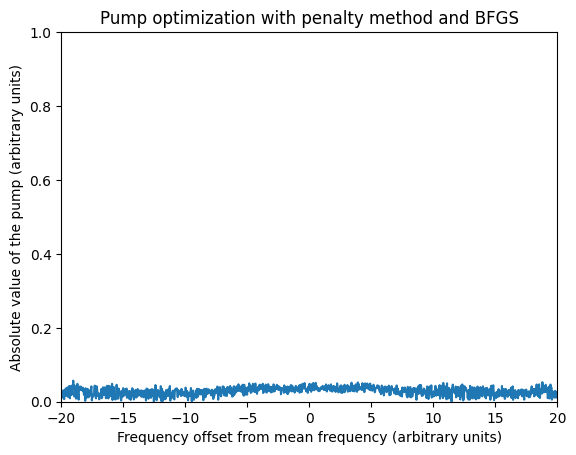

In [14]:
from matplotlib import animation
from functools import partial
from IPython import display

fig = plt.figure()

lines = plt.plot([])
line = lines[0]

def animate(frame, pumps):
    y = pumps[frame]
    line.set_data(freq_range_pump, y)
    return None
plt.xlim(freq_range_pump[0], freq_range_pump[-1])
plt.ylim(0, 1)
plt.title("Pump optimization with penalty method and BFGS")
plt.xlabel("Frequency offset from mean frequency (arbitrary units)")
plt.ylabel("Absolute value of the pump (arbitrary units)")
A = [jnp.abs(opt.get_complex_array(i)) for i in (pumps_for_k[0]+ pumps_for_k[1] +  pumps_for_k[2])]
anim = animation.FuncAnimation(fig, partial(animate, pumps = A),  frames=len(A), interval=400)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Now, let us see what happens if we were to use the Hermitian polynomial multiplied with the Gaussian instead. 

In [17]:
hermitian_pump = arbitrary_seed_hermite.copy()
hermitian_pumps_for_k = []
for i in range(25):
    print("run " + str(i))
    hermitian_pumps = []
    for j in range(15):
        (hermitian_pump, state) = solver.run(hermitian_pump, N, alpha, G, H, l, y_N, freq_range_pump, 2**i)
        hermitian_pumps.append(hermitian_pump.copy())
    hermitian_pumps_for_k.append(hermitian_pumps)

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14



KeyboardInterrupt



Here we will plot out the absolute value of the optimal pump when the seed is random and when the seed is a Hermitian polynomial multiplied by a Gaussian

In [18]:
abs_pump = jnp.abs(opt.get_complex_array(pump))
abs_hermit_pump = jnp.abs(opt.get_complex_array(hermitian_pump))
phase_pump = jnp.angle(opt.get_complex_array(pump))
phase_hermit_pump = jnp.angle(opt.get_complex_array(hermitian_pump))
display_plot = [abs_pump, abs_hermit_pump, phase_pump, phase_hermit_pump]
display_leg = ["absolute value with random pump", "absolute value with Hermitian pump", "phase value with random pump", "phase value with Hermitian pump"]

In [5]:
import display_res as disp

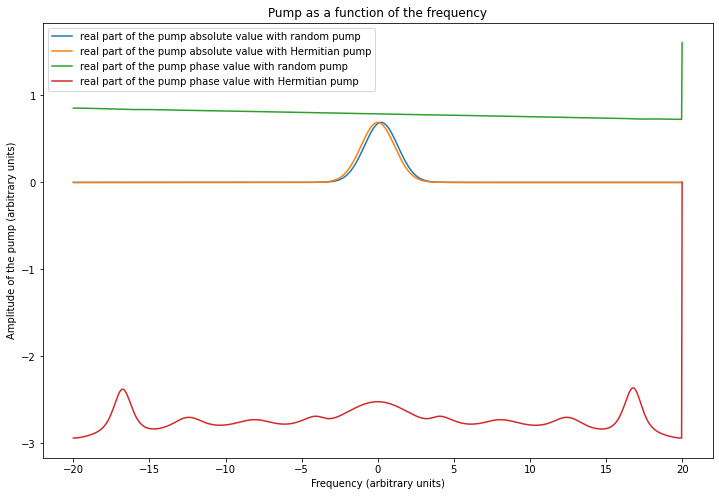

In [19]:
disp.plot_pump(display_plot, freq_range_pump, display_leg)

And the purity for the optimal pump with random seed and Hermitian seed are respectively

In [20]:
print("Schmidt number with random seed: ", opt.get_observables(pump, N, alpha, G, H, l)[1])
print("Mean photon pair number with random seed: ", opt.get_observables(pump, N, alpha, G, H, l)[0])
print("Schmidt number with Hermitian seed: ", opt.get_observables(hermitian_pump, N, alpha, G, H, l)[1])
print("Mean photon pair number with Hermitian seed: ", opt.get_observables(hermitian_pump, N, alpha, G, H, l)[0])

Schmidt number with random seed:  1.0931693
Mean photon pair number with random seed:  3.0001311
Schmidt number with Hermitian seed:  1.09343
Mean photon pair number with Hermitian seed:  3.0008297


We can see that after optimization, the absolute value of the optimal pump initialized with random seed and Hermitian seed overlap. This overlapping shape also looks Gaussian. One would then be led to believe 2 things; first that the lower bound on the Schmidt number for an average pair number per pulse of 3 is 1.12 and second that the optimal pump seems to be Gaussian. Let us see if the second point hold.

## Optimization of a Gaussian

Now, suppose the optimal pump is truly Gaussian, only 3 parameters are needed, which are the amplitude of the Gaussian, its width and the phase for a complex pump. Let us generate the seeds for these 3 parameters. First, we need to import the modules to realize the optimization scheme.

In [6]:
import optimization_SPDC_gaussain_pump as opt_gauss

Now, let us use the same parameters for the Gaussian seed to generate an optimization scheme restricted to Gaussian pumps and the same solver as before with penalty method.

In [24]:
params = [gaussian_amplitude, gaussian_width, phase]
gauss_solver = jaxopt.ScipyMinimize(method = "BFGS", fun=opt_gauss.get_penalty_loss, maxiter=20, jit= False)
theta = params.copy()
for i in range(15):
    print("run number " + str(i))
    (theta, state) = gauss_solver.run(theta, freq_range_pump, alpha, G, H, l, y_N, 3**i)

run number 0
run number 1
run number 2
run number 3
run number 4
run number 5
run number 6
run number 7
run number 8
run number 9
run number 10
run number 11
run number 12
run number 13
run number 14


Comparing the normalized absolute value of the optimal pump when pump values were arbitrary and the optimal pump when restricted to a Gaussian, one can see that the shape is almost identical.

In [32]:
Nownorm_gauss_pump = jnp.abs(opt_gauss.get_gaussian_pump(theta, freq_range_pump))/jnp.linalg.norm(opt_gauss.get_gaussian_pump(theta, freq_range_pump))
norm_arb_hermitian_pump = (abs_hermit_pump/jnp.linalg.norm(abs_hermit_pump))
comparison_leg = ["optimal pump when every element is a parameter", "optimal Gaussian pump"]

(DeviceArray(3.0009482, dtype=float32), DeviceArray(1.088198, dtype=float32))

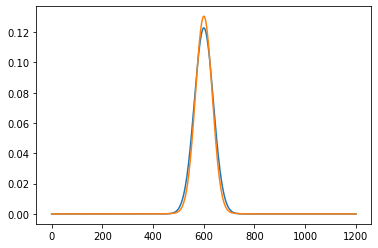

In [33]:
disp.plot_pump([norm_gauss_pump, norm_arb_hermitian_pump], freq_range_pump, comparison_leg)

Doing the cross correlation between the optimal pump, one realizes that the likelihood is 

In [37]:
print("Normalized cross correlation between the Gaussian pump and the arbitrary pump is " + str(norm_gauss_pump@norm_arb_hermitian_pump))

Normalized cross correlation between the Gaussian pump and the arbitrary pump is 0.996406


This result is interesting, because for low gain ($n \ll 1$), it has been proven analytically through perturbative regime that to obtain purely separable joint spectral amplitude, a Gaussian phase matching function and a Gaussian pump are needed (Quesada and Branczyk, 2018). A numerical optimization scheme was performed with an objective function stemming from low-gain regime, which is a restricted case of the general SPDC in waveguides. Let us compare how does the optimal pump obtained theorically fare in high gain regime with the Gaussian pumps obtained with optimization at high gain.

# Comparing low gain optimal pump at high gain with optimized pump at this high gain

A main difference between the low-gain regime and high gain regime is the presence of higher Fock state terms in the output state. If the phase matching function (PMF) is not Gaussian, an approximation that is closest to a Gaussian is preferable. For a sinc PMF of the form $\frac{\sin \left(\kappa (x-y)\right)}{x-y}$, the width of the Gaussian should be of $\frac{1.61}{1.13}\kappa$ to have maximal separability. Let us generate a pump with such a width.

In [29]:
ratio = 1.61/1.13
vi = vp / (1 - 2 * ratio * vp / l)
vs = vp / (1 + 2 * ratio * vp / l)
width = jnp.sqrt(ratio/(l*(1/vp - 1/vi)))
theta = [0.01, width, 0.1]
low_pump = opt_gauss.get_gaussian_pump(theta,freq_range_pump)

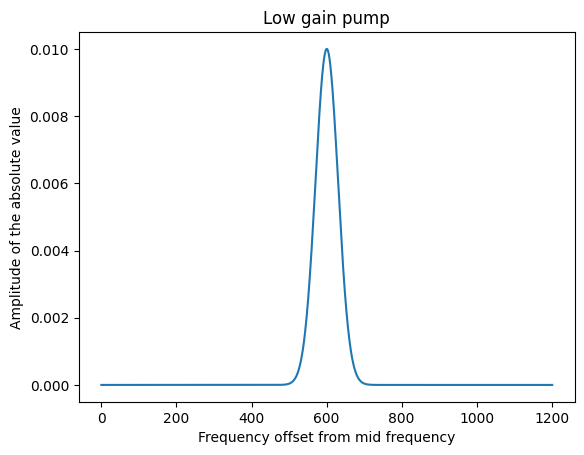

In [32]:
plt.title("Low gain pump")
plt.xlabel("Frequency offset from mid frequency")
plt.ylabel("Amplitude of the absolute value")
plt.plot(np.abs(low_pump))

The joint spectral amplitude would look like

In [ ]:
JSA = gauss_opt.get_JSA(theta, freq_range_pump, alpha, G, H, l)
fig, ax = plt.subplots()
im = ax.imshow(JSA, cmap="jet", origin="lower",extent=[x[0],x[N-1],x[0],x[N-1]])
ax.set_title("JSA with 10 N value")
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
plt.colorbar(im, orientation="vertical")
plt.show()Now

Now, let $n$ value taking the values $\{0.5, 1, 1.5, 2, 2.5, 3\}$, let us see what the optimized Gaussian pump should look like at these values

In [7]:
params = [gaussian_amplitude, gaussian_width, phase]
gauss_solver = jaxopt.ScipyMinimize(method = "BFGS", fun=opt_gauss.get_penalty_loss, maxiter= 10, jit= False)

In [8]:
y_Ns = [0.5, 1., 1.5, 2., 2.5, 3.]
theta_per_y_N = []
for n in y_Ns:
    theta = params.copy()
    for i in range(15):
        print("run number " + str(i))
        (theta, state) = gauss_solver.run(theta, freq_range_pump, alpha, G, H, l, n, 3**i)
        theta_per_y_N.append(theta.copy())

run number 0
run number 1



KeyboardInterrupt



In [ ]:
diff_n_schmidt_numbers = []
for i in range(len(theta_per_y_N)):
    diff_n_schmidt_numbers.append(opt_gauss.get_observables(theta_per_y_N[i], freq_range_pump, alpha, G, H, l)[1])

For the same values of $n$, let us take Gaussian pumps with width optimized for low gain and find the Schmidt number associated with each case.

In [133]:
amps = [0.3845, 0.5068, 0.5856, 0.64356, 0.689181, 0.72667]
schmidt_numbers_low = []
for amp in amps:
    diff_theta = [amp, width, 0.1]
    schmidt_numbers_low.append(opt_gauss.get_observables(diff_theta, freq_range_pump, alpha, G, H, l)[1])

Now, we can compare them by plotting the Schmidt number as function of mean number of photon pairs per pulse

NameError: name 'diff_n_schmidt_numbers' is not defined

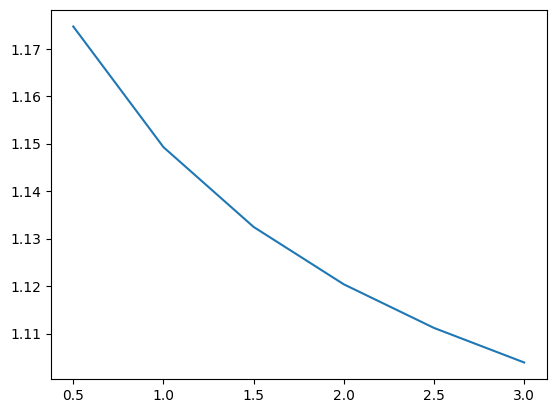

In [138]:
plt.plot(y_Ns, schmidt_numbers_low)
plt.plot(y_Ns, diff_n_schmidt_numbers)

Comparing the Schmidt number, we see that the pump optimized for low gain does not seem to be optimal for high gain.